In [2]:
from sklearn.cluster import KMeans
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import random
import hyperloglog

## 1. HASHING

- https://en.wikipedia.org/wiki/Fowler%E2%80%93Noll%E2%80%93Vo_hash_function#FNV-1_hash
- https://github.com/sup/pyhash/blob/master/pyhash/pyhash.py
- https://www.geeksforgeeks.org/what-are-hash-functions-and-how-to-choose-a-good-hash-function/
- http://www.euroinformatica.ro/documentation/programming/!!!Algorithms_CORMEN!!!/DDU0066.html
- https://github.com/svpcom/hyperloglog

In [ ]:
def importing_requests(file):
    f=open(file,'r')
    requests = f.read().split('\n')
    return requests

https://medium.com/@raghavan99o/hyperloglog-algorithm-part-i-flajolet-martin-algorithm-b4dcc9be3031

In [ ]:
def convert(string):
    s=0
    for char in string:
        s+=ord(char)
    return int(s)

In [ ]:
def my_hash(string):
    n = 106033 # must be greater than expected size
    IP = string
    r = int(len(IP)/2)
    q = [IP[:r//2],IP[r//2:r],IP[r:r+r//2],IP[r+r//2:]]
    a=[2,17,4,32]
    h=0

    for i in range(4):
        x = int(convert(q[i]))
        h += (x*a[i])%n
    return str(bin(h).split('b')[1])

In [ ]:
# 125000001 real len of set

def HLL_real(file,nlines):
    f = open(file, "r")
    hll = hyperloglog.HyperLogLog(0.01)  # accept 1% counting error
    for n in range(1,nlines):
        req = f.readline(n)
        hll.add(h)
    
    return len(hll) 

https://pangaj.github.io/HyperLogLog/

In [ ]:
def tail_zeros(b):
    i = 1
    while b[-i] == '0' and i<len(b):
        i+=1
    return i

In [ ]:
def HLL(file,nlines):
    f = open(file, "r")
    B = []
    buckets = [0]*4
    for n in range(1,nlines): # 139000000, 100001
        req = f.readline(n)
        b = my_hash(req)
        B.append(b[1:])
        index = int(b[1])*2 + int(b[2]) 
        zeros = tail_zeros(b[2:])
        buckets[index]=max(buckets[index],zeros) 
    cardinality = 2**np.mean(buckets)
    #loglog = np.log(np.log(cardinality))
    error = (1.3/math.sqrt(4))*(n/100)
    return cardinality, buckets, error, B

In [ ]:
c,b,e,B = HLL('small.txt',100001)

In [ ]:
print(HLL_real('small.txt',100001))

## 2. CLUSTERING

#### Importing dataset

In [3]:
dataset = pd.read_csv('Reviews.csv',nrows=1000)
dataset['ProfileName'].fillna('',inplace=True)
dataset['Summary'].fillna('',inplace=True)
dataset.set_index('Id',inplace=True)
pd.to_datetime(dataset.iloc[8].Time,unit='s')
dataset['Datetime'] = dataset.Time.apply(lambda value: pd.to_datetime(value, unit='s'))

#### Preprocessing

In [4]:
def preprocessing(file):
    # TF-IDF
    # SVD method
    # remove very common words
    return df

### K-Means

Testing with random distance matrix

In [5]:
N = 100
b = np.random.uniform(0, 1, size=(N,N))
m = (b + b.T)/2

K-means algorithm that is inizialized with random points and a number of clusters k. It returns a dictionary where the keys are the cluster ids, the ids of the random centroids, the clusters id associated to each centroid and the within cluster squared score.

In [6]:
def kmeans(k, matrix,centroids):   
    n_clusters = dict(zip(centroids,range(k)))            # cluster number centroids
    clusters = {i: [] for i in range(k)}                  # empty dictionary for clusters
    WSS = {i: 0 for i in range(k)}                        # will be used to calculate within cluster sum of squares
    for point in range(len(matrix)):                      # for each point 
        dist = 1                                          # we assume max dist in a range 0-1
        for center in centroids:                          # for each centroid
            if matrix[point][center] < dist:              # we check if the distance between the point and the centroid is smaller than the previous dist
                cluster_id = n_clusters[center]           # assignes to cluster is k
                dist = matrix[point][center]              # update distance
        clusters[cluster_id].append(point)                # update with best cluster
        WSS[cluster_id]+=dist                             # updating the chosed cluster with the squared distance 
    WSS = np.mean([WSS[i]/len(clusters[i]) for i in range(k)])  # calculate mean distance for each cluster
    return clusters, centroids, n_clusters, WSS

### Evaluating optimal number of clusters: 
Links: 
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/
- https://www.youtube.com/watch?v=AtxQ0rvdQIA
- https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
- https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
- https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb

**Elbow method**: 
- Compute clustering algorithm for different values of k.
- For each k, calculate the total within-cluster sum of square (wss).
- Plot the curve of wss according to the number of clusters k.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
WSS: measures the squared average distance of all the points within a cluster to the cluster centroid. To calculate WCSS, you first find the Euclidean distance between a given point and the centroid to which it is assigned. You then iterate this process for all points in the cluster, and then sum the values for the cluster and divide by the number of points. Finally, you calculate the average across all clusters. 

In [7]:
def elbow_method(matrix,threshold):
    elbow = []
    ks = range(5,20)
    for k in ks:                                              # for each number of clusters
        centroids = random.sample(range(1, len(matrix)), k)   # pick random points
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids)
        elbow.append(WSS)                                     # we append for each iteration the WSS score
    i = 1                                                     
    optimal = 0                                               # we want to best compromise btw low n of clusters and low WSS
    while elbow[i-1] - elbow[i] > elbow[i]*threshold:         # we stop when the variation is lower then a certain percentage of the WSS value at that iteration        
        i+=1
        optimal = elbow[i]
    
    print('Elbow method: Optimal number of clusters is',ks[i])
    plt.figure(figsize=(8,5));
    plt.plot(ks,elbow);
    return elbow, ks[i]

**Silhouette method**:
- We vary k from 1 to 10 clusters.
- For each k, calculate the average silhouette of observations
- Plot the curve of avg.sil according to the number of clusters k.
- The location of the maximum is considered as the appropriate number of clusters

In [8]:
def silhouette_method(matrix):
    ks = range(5,20)
    points = {i: {} for i in ks} 
    scores = {}
    for k in ks:                                                      # for each number of clusters
        centroids = random.sample(range(1, len(matrix)), k)           # pick random points
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids)# we apply k-means
        s_score = {}
        points = {}                                                   # add a dictionary where keys are the point and clusters id are the value
        for cluster in clusters.keys():                               # for each cluster in k-means
            points.update(dict(zip(clusters[cluster],[cluster]*len(clusters[cluster])))) # update points dictionary
        for point1 in points.keys():                                  # for each point
            point1_cluster = points[point1]                           # we extract its cluster
            in_distance = 0
            out_distance = 0
            points_in = clusters[point1_cluster]                      # points in same cluster
            points_out = set(points.keys()).difference(set(points_in))# any other point
            for point2 in points_in:                                  # for each point in the same cluster
                in_distance+=matrix[point1][point2]                   # we add distance btw point1 and point2 to in_distance
            for point2 in points_out:                                 # for each any other point 
                out_distance+=matrix[point1][point2]                  # we add distance btw point1 and point2 to out_distance
            avarage_in = in_distance/len(points_in)                   # we compute avarage distance for both
            avarage_out = out_distance/len(points_out)
            s = (avarage_out-avarage_in)/max(avarage_in,avarage_out)  # we calculate silhouette score
            s_score[point1]=s                                         # we store sil_score for each point
        scores[k]=s_score
    df=pd.DataFrame.from_dict(scores)
    print('Silhouette method: Optimal number of clusters is',df.columns[df.sum().argmax()])
    return scores, df.columns[df.sum().argmax()]

#### Trying different random initializations

In [13]:
def kmeans_optimize(k,matrix,iterations):
    
    # inizialization
    plot_data={}
    all_wss = []
    all_centers = []
    
    # simulations
    for i in range(iterations):                               # for each simulation
        centroids = random.sample(range(1, len(matrix)), k)     # pick random points
        itr = []
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids) # a different set of random centroids is generated
        for n in n_clusters.values():                         # for each cluster 
            itr.append(len(clusters[n])/len(m))               # we save the percentage of point it contains
        plot_data['iter_'+str(i)]=itr                         # save data to plot for each iteration
        all_wss.append(WSS)                                   # save WSS for each iteration
        all_centers.append(centers)                           # save centroids
    
    # plotting
    colors = sns.color_palette("Pastel1")
    pd.DataFrame.from_dict(plot_data,orient='index').plot.barh(stacked=True,color=colors, figsize=(8,5))
    plt.legend(loc='best',bbox_to_anchor=(0.7,0.5, 0.5, 0.5));
    
    # defining best result
    best = all_wss.index(min(all_wss))                       # the best result is that with lowest wss score
    print('The best iteration is', best,' whith centroids:', all_centers[best])
    return plot_data,all_centers,all_wss,best

In [14]:
def initialize(matrix,iterations):
    
    # optimal number of clusters methods:
    # 1. elbow method
    scores_e, e = elbow_method(matrix,0.02)
    # 2. silhouette method
    scores_s, s = silhouette_method(matrix)
    # 3. gap statistic method
    
    # best number of clouds
    k = (e+s)//2
    
    # randomly picking points
    plot_data,all_centers,all_wss,best = kmeans_optimize(k,m,iterations)
    centroids = all_centers[best]
    
    return centroids, k

Elbow method: Optimal number of clusters is 7
Silhouette method: Optimal number of clusters is 19
The best iteration is 0  whith centroids: [52, 50, 19, 95, 77, 31, 36, 66, 10, 81, 4, 84, 65]


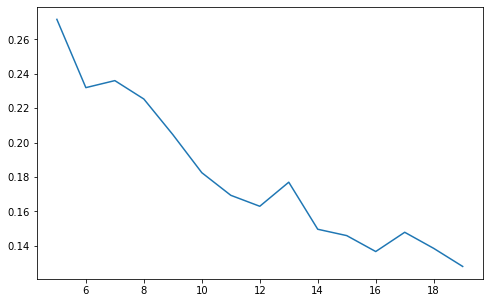

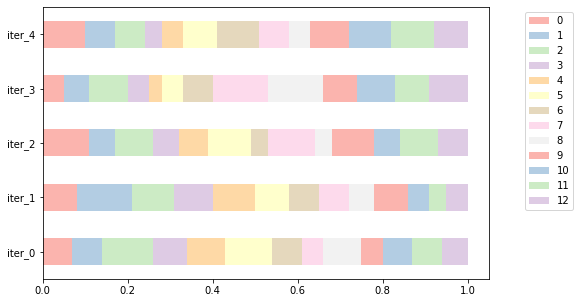

In [15]:
optimal_centroids, optimal_k = initialize(m,5)

In [16]:
clusters, centroids, n_clusters, WSS= kmeans(optimal_k,m,optimal_centroids)
clusters

{0: [3, 17, 23, 29, 38, 65, 82],
 1: [0, 32, 43, 51, 81, 89, 97],
 2: [11, 12, 21, 26, 27, 30, 31, 53, 72, 84, 94, 96],
 3: [2, 4, 5, 6, 44, 70, 78, 90],
 4: [14, 37, 39, 63, 73, 74, 79, 80, 91],
 5: [8, 13, 19, 55, 64, 67, 76, 83, 88, 98, 99],
 6: [20, 24, 35, 49, 58, 60, 71],
 7: [9, 42, 68, 69, 77],
 8: [1, 10, 34, 40, 46, 47, 56, 59, 92],
 9: [15, 33, 50, 54, 61],
 10: [16, 25, 28, 41, 66, 85, 95],
 11: [18, 22, 48, 62, 86, 87, 93],
 12: [7, 36, 45, 52, 57, 75]}

### Comapring to built in k-means ++

In [ ]:
def k_means_pp(reviews):
    # built in https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    return clusters2

In [ ]:
def compare(clusters1,clusters2):
    return comparison

### Visualizing results

In [ ]:
def word_cloud(cluster):
    return plots

In [ ]:
def score_distribution(cluster):
    return score

In [ ]:
def analyze(clusters):
    for cluster in clusters:
        plots = word_cloud(cluster)
        numberOfProds = set(df.products)
        scoreDistro = score_distribution(cluster)
        uniqueUsers = set(df.users)
    return plots, numberOfProds, scoreDistro, uniqueUsers

## 3. ARLGORITHM
Prove that we can sort A in time O(n + r).
https://it.wikipedia.org/wiki/Counting_sort

In [ ]:
s = min{ A[1], ..., A[n] } 
b = max { A[1], ..., A[n] }.
r = b - s